# Set Initial Parameters
---

In [1]:
import pyspark
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("spark")\
.config('spark.driver.memory', '48g')\
.config("hive.server2.thrift.port", 10000)\
.config("spark.sql.hive.thriftServer.singleSession", True)\
.config("spark.driver.maxResultSize", "10g")\
.enableHiveSupport()\
.getOrCreate()

22/04/25 19:19:17 WARN Utils: Your hostname, Ewins-Mac-Hex.local resolves to a loopback address: 127.0.0.1; using 192.168.0.47 instead (on interface en0)
22/04/25 19:19:17 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/04/25 19:19:18 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
mode = "full"

# Initialization
---

### Loading the required Libraries for Time-Series Analysis

In [3]:
%pip install FBProphet

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [4]:
import logging
logging.getLogger('py4j').setLevel(logging.ERROR)

### Loading the data

In [6]:
df1 = spark.read.format('parquet').load("/Users/minoseah629/Repos/AIT614Project/ewin/spark-warehouse/ait614projectpermanenttable")

In [8]:
df1.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- Speed: double (nullable = true)
 |-- TravelTime: integer (nullable = true)
 |-- Status: integer (nullable = true)
 |-- timedate: timestamp (nullable = true)
 |-- LinkId: integer (nullable = true)
 |-- LinkPoints: string (nullable = true)
 |-- EncodedLinkPoints: string (nullable = true)
 |-- EncodedPolyLineLvls: string (nullable = true)
 |-- Owner: string (nullable = true)
 |-- TranscomId: integer (nullable = true)
 |-- Borough: string (nullable = true)
 |-- Link_Name: string (nullable = true)



In [9]:
df1 = df1.withColumnRenamed("Speed", "speed")
df1 = df1.withColumnRenamed("timedate", "ds")
df1 = df1.withColumnRenamed("LinkId", "link_id")


In [10]:
from pyspark.sql.types import StringType
df1 = df1.withColumn("link_id",df1.link_id.cast('string'))

In [14]:
df = df1.select('ds', 'link_id', 'speed')

In [15]:
# Filtering records within 2018 to 2021
df = df.filter(df.ds >= '2018-01-01')
df = df.filter(df.ds < '2022-01-01')

In [16]:
df.cache()
df.printSchema()
df.show(10)

root
 |-- ds: timestamp (nullable = true)
 |-- link_id: string (nullable = true)
 |-- speed: double (nullable = true)



+-------------------+-------+-----+
|                 ds|link_id|speed|
+-------------------+-------+-----+
|2021-12-07 17:58:03|4329507|16.77|
|2021-12-07 17:58:03|4362244|45.98|
|2021-12-07 17:58:03|4362247|41.63|
|2021-12-07 17:58:03|4362249|24.85|
|2021-12-07 17:58:03|4362250|49.08|
|2021-12-07 17:58:03|4362251|27.34|
|2021-12-07 17:58:03|4362252|38.52|
|2021-12-07 17:58:03|4362314|40.38|
|2021-12-07 17:58:03|4362342| 9.32|
|2021-12-07 17:58:03|4456479|39.14|
+-------------------+-------+-----+
only showing top 10 rows



In [17]:
df.createOrReplaceTempView('data')

# Time-Seriers Analysis | Entire Dataset
---

## Basic Time-Series Data Exploration on entire dataset

#### Overall Trend

In [ ]:
%sql
 
SELECT DATE_TRUNC('day', ds) AS Day_Year, AVG(speed) AS Average_Traffic_Speed
FROM data
GROUP BY Day_Year
ORDER BY Day_Year;

Day_Year,Average_Traffic_Speed
2018-01-01T00:00:00.000+0000,36.67771322016653
2018-01-02T00:00:00.000+0000,34.119815656305846
2018-01-03T00:00:00.000+0000,32.98334636857141
2018-01-04T00:00:00.000+0000,30.634843905243343
2018-01-05T00:00:00.000+0000,34.427746031745365
2018-01-06T00:00:00.000+0000,38.29925203252137
2018-01-07T00:00:00.000+0000,39.837936766037025
2018-01-08T00:00:00.000+0000,35.400232546135705
2018-01-09T00:00:00.000+0000,34.50512319958848
2018-01-10T00:00:00.000+0000,35.96463962920169


In [ ]:
%sql

SELECT DATE_TRUNC('MM', ds) AS Month_Years, AVG(speed) AS Average_Traffic_Speed
FROM data
GROUP BY Month_Years
ORDER BY Month_Years;

Month_Years,Average_Traffic_Speed
2018-01-01T00:00:00.000+0000,34.878041715991856
2018-02-01T00:00:00.000+0000,35.53370490309543
2018-03-01T00:00:00.000+0000,34.56733090941101
2018-04-01T00:00:00.000+0000,35.50463205036818
2018-05-01T00:00:00.000+0000,35.04053558758282
2018-06-01T00:00:00.000+0000,34.45224063592429
2018-07-01T00:00:00.000+0000,34.990856519580284
2018-08-01T00:00:00.000+0000,32.643363332116216
2018-09-01T00:00:00.000+0000,34.6933258642836
2018-10-01T00:00:00.000+0000,32.71456955887308


#### Annual Pattern

In [ ]:
%sql

SELECT DATEADD(DAYOFYEAR, DAYOFYEAR(ds), '1999-12-31') day_month, AVG(speed)
FROM data
GROUP BY day_month
ORDER BY day_month;

day_month,avg(speed)
2000-01-01T00:00:00.000+0000,39.903223961101006
2000-01-02T00:00:00.000+0000,38.03118485639404
2000-01-03T00:00:00.000+0000,37.678565982696114
2000-01-04T00:00:00.000+0000,37.18708991537567
2000-01-05T00:00:00.000+0000,38.62827184006825
2000-01-06T00:00:00.000+0000,38.96370006649342
2000-01-07T00:00:00.000+0000,38.572402772381224
2000-01-08T00:00:00.000+0000,37.23358416043386
2000-01-09T00:00:00.000+0000,36.75890992897381
2000-01-10T00:00:00.000+0000,37.46707959023981


In [ ]:
%sql

SELECT MONTH(ds) AS Month, AVG(speed) AS Average_Traffic_Speed
FROM data
GROUP BY Month
ORDER BY Month;

Month,Average_Traffic_Speed
1,36.977405912790516
2,36.41923838387955
3,36.11669829764618
4,36.90945400805463
5,36.38721423953426
6,35.111146307561924
7,35.26034420223903
8,34.292668730970576
9,34.992388926561354
10,35.08664318252439


In [ ]:
%sql

SELECT DATEADD(DAYOFYEAR, DAYOFYEAR(ds), '1999-12-31') day_month, YEAR(ds) AS Year, AVG(speed)
FROM data
GROUP BY day_month, Year
ORDER BY day_month;

day_month,Year,avg(speed)
2000-01-01T00:00:00.000+0000,2019,38.88621215640933
2000-01-01T00:00:00.000+0000,2021,42.639219355059936
2000-01-01T00:00:00.000+0000,2020,42.02584832134418
2000-01-01T00:00:00.000+0000,2018,36.67771322016653
2000-01-02T00:00:00.000+0000,2019,38.64472499677628
2000-01-02T00:00:00.000+0000,2021,39.99759692861887
2000-01-02T00:00:00.000+0000,2020,40.20043014539549
2000-01-02T00:00:00.000+0000,2018,34.119815656305846
2000-01-03T00:00:00.000+0000,2018,32.98334636857141
2000-01-03T00:00:00.000+0000,2020,38.470995162059474


In [ ]:
%sql

SELECT YEAR(ds) AS Year, Month(ds) AS Month, AVG(speed) AS Speed
FROM data
GROUP BY Year, Month
ORDER BY Year, Month;

Year,Month,Speed
2018,1,34.878041715991856
2018,2,35.53370490309543
2018,3,34.56733090941101
2018,4,35.50463205036818
2018,5,35.04053558758282
2018,6,34.45224063592429
2018,7,34.990856519580284
2018,8,32.643363332116216
2018,9,34.6933258642836
2018,10,32.71456955887308


#### Weekly Pattern

In [ ]:
%sql

SELECT DATEADD(HOUR, HOUR(ds), DATEADD(DAY, DAYOFWEEK(ds), '2000-09-30') ) hour_day, AVG(speed)
FROM data
GROUP BY hour_day
ORDER BY hour_day;

hour_day,avg(speed)
2000-10-01T00:00:00.000+0000,34.340479282840214
2000-10-01T01:00:00.000+0000,35.834671307789996
2000-10-01T02:00:00.000+0000,36.95939507915149
2000-10-01T03:00:00.000+0000,37.511855025949004
2000-10-01T04:00:00.000+0000,38.244993367386726
2000-10-01T05:00:00.000+0000,38.89329383186153
2000-10-01T06:00:00.000+0000,39.15527015709863
2000-10-01T07:00:00.000+0000,39.17798090484728
2000-10-01T08:00:00.000+0000,39.801604323821095
2000-10-01T09:00:00.000+0000,41.62219261027257


In [ ]:
%sql

SELECT DAYOFWEEK(ds) day, AVG(speed)
FROM data
GROUP BY day
ORDER BY day;

day,avg(speed)
1,37.64107995827201
2,35.78364118193846
3,35.49594976075381
4,35.372233043338504
5,34.77104121230205
6,34.4641959159848
7,36.722866941239914


In [ ]:
%sql

SELECT DATEADD(HOUR, HOUR(ds), DATEADD(DAY, DAYOFWEEK(ds), '2000-09-30') ) day, YEAR(ds) AS Year, AVG(speed)
FROM data
GROUP BY day, Year
ORDER BY day;

day,Year,avg(speed)
2000-10-01T00:00:00.000+0000,2020,38.95535586675921
2000-10-01T00:00:00.000+0000,2018,32.78251354889217
2000-10-01T00:00:00.000+0000,2021,32.93078795590632
2000-10-01T00:00:00.000+0000,2019,33.111188543959415
2000-10-01T01:00:00.000+0000,2021,34.697288159195544
2000-10-01T01:00:00.000+0000,2019,34.41638010093325
2000-10-01T01:00:00.000+0000,2020,40.12322875947116
2000-10-01T01:00:00.000+0000,2018,34.42967270161054
2000-10-01T02:00:00.000+0000,2018,35.53502480104294
2000-10-01T02:00:00.000+0000,2019,35.63077673839756


In [ ]:
%sql

SELECT DAYOFWEEK(ds) day, YEAR(ds) AS Year, AVG(speed)
FROM data
GROUP BY day, Year
ORDER BY day;

day,Year,avg(speed)
1,2018,36.3189175362895
1,2021,36.56446049780325
1,2019,36.65371543134041
1,2020,41.2021437427035
2,2018,34.808505414381614
2,2021,34.466811613885454
2,2020,39.214158172204
2,2019,34.84791203260501
3,2019,34.54471991570394
3,2021,34.52116420023339


#### Daily Pattern

In [ ]:
%sql

SELECT (MINUTE(ds) + HOUR(ds) * 60) / 60 AS minute_hour, AVG(speed) AS Average_Traffic_Speed
FROM data
GROUP BY minute_hour
ORDER BY minute_hour;

minute_hour,Average_Traffic_Speed
0.0,30.95968051118211
0.016666666666666666,29.268626760563382
0.03333333333333333,31.461167876331388
0.05,34.0998813207848
0.06666666666666667,36.872358517667216
0.08333333333333333,31.274432882414143
0.1,32.49031422271224
0.11666666666666667,31.60229706034039
0.13333333333333333,34.4074612816003
0.15,37.02590894285388


In [ ]:
%sql

SELECT HOUR(ds) AS Hour, AVG(speed) AS Average_Traffic_Speed
FROM data
GROUP BY Hour
ORDER BY Hour;

Hour,Average_Traffic_Speed
0,35.271281569420864
1,36.90972523846214
2,37.80335804226358
3,38.223096066626006
4,38.613825790404384
5,38.84561481053182
6,39.125724924952365
7,39.877810028361004
8,41.427498378244046
9,42.48073401662958


In [ ]:
%sql

SELECT (MINUTE(ds) + HOUR(ds) * 60) / 60 AS minute_hour, YEAR(ds) AS year, AVG(speed) AS Average_Traffic_Speed
FROM data
GROUP BY minute_hour, year
ORDER BY minute_hour, year;

minute_hour,year,Average_Traffic_Speed
0.0,2018,29.362237442922346
0.0,2019,28.467122186495164
0.0,2020,0.0
0.0,2021,36.47042394014964
0.016666666666666666,2018,22.048705035971214
0.016666666666666666,2019,29.554542974079126
0.016666666666666666,2020,30.58225
0.016666666666666666,2021,32.578660714285704
0.03333333333333333,2018,31.745773900742677
0.03333333333333333,2019,30.504610389610296


In [ ]:
%sql

SELECT HOUR(ds) AS Day, YEAR(ds) AS Year, AVG(speed) AS Speed
FROM data
GROUP BY Day, Year
ORDER BY Day, Year;

Day,Year,Speed
0,2018,33.8766000827083
0,2019,33.85589416146232
0,2020,39.40019367340128
0,2021,34.313426012541264
1,2018,35.748532343061996
1,2019,35.651187278002794
1,2020,40.460740279493166
1,2021,36.11022081428477
2,2018,36.721472013341085
2,2019,36.76599563277109


## Training Time-Series Model

In [18]:
# Filtering data from 2018 to June 2021 as training set. Reducing the training set any further will directly impact the model accuracy, due to fluctuations in 2020 data during COVID-19 pandemic.

train = '''
SELECT ds, AVG(speed) AS y
FROM data
GROUP BY ds
ORDER BY ds;
'''

df_train = spark.sql(train).toPandas()

In [ ]:
# Filtering data from July 2021 to December 2021 as testing set.

#test = '''
#SELECT ds, AVG(speed) AS y
#FROM data
#WHERE ds >= '2022-01-01'
#GROUP BY ds
#ORDER BY ds;
#'''
#
#df_test = spark.sql(test).toPandas()

In [19]:
# Training the prophet model on the training set
from fbprophet import Prophet

ts_model = Prophet(
    interval_width=0.9,
    daily_seasonality=True,
    weekly_seasonality=True,
    yearly_seasonality=False
)

ts_model.fit( df_train )

/Users/minoseah629/Library/Python/3.8/lib/python/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -31241.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Exception: normal_lpdf: Scale parameter is 0, but must be > 0!  (in 'unknown file name' at line 136)

Exception: normal_lpdf: Scale parameter is 0, but must be > 0!  (in 'unknown file name' at line 136)

Error evaluating model log probability: Non-finite gradient.
Error evaluating model log probability: Non-finite gradient.

      99    3.5651e+06    0.00142359       52638.2       0.554       0.554      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199   3.56711e+06      0.010143       21208.3           1           1      236   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299   3.56949e+06      0.011928       61752.5           1           1      354   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
   

In [21]:
# Predicting future for 'fut' more days

fut = 365*24*2
df_future = ts_model.make_future_dataframe(
    periods=fut,
    freq='H',
    include_history=True
)

# predict over the dataset
df_forecast = ts_model.predict(df_future)

display(df_forecast)

/Users/minoseah629/Library/Python/3.8/lib/python/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/minoseah629/Library/Python/3.8/lib/python/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2018-01-01 00:02:09,32.085500,15.287052,56.198385,32.085500,32.085500,3.235958,3.235958,3.235958,2.513521,2.513521,2.513521,0.722437,0.722437,0.722437,0.0,0.0,0.0,35.321457
1,2018-01-01 00:02:10,32.085500,14.670893,55.652283,32.085500,32.085500,3.235767,3.235767,3.235767,2.513353,2.513353,2.513353,0.722414,0.722414,0.722414,0.0,0.0,0.0,35.321266
2,2018-01-01 00:02:12,32.085499,14.384203,55.282390,32.085499,32.085499,3.235386,3.235386,3.235386,2.513017,2.513017,2.513017,0.722368,0.722368,0.722368,0.0,0.0,0.0,35.320885
3,2018-01-01 00:02:13,32.085499,14.066737,56.524550,32.085499,32.085499,3.235195,3.235195,3.235195,2.512850,2.512850,2.512850,0.722346,0.722346,0.722346,0.0,0.0,0.0,35.320694
4,2018-01-01 00:02:17,32.085498,13.081505,53.838910,32.085498,32.085498,3.234433,3.234433,3.234433,2.512179,2.512179,2.512179,0.722255,0.722255,0.722255,0.0,0.0,0.0,35.319932
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2551772,2023-12-31 19:59:13,34.163111,-203.246586,288.317246,-200.645049,287.763001,-0.046521,-0.046521,-0.046521,-1.113548,-1.113548,-1.113548,1.067027,1.067027,1.067027,0.0,0.0,0.0,34.116591
2551773,2023-12-31 20:59:13,34.163196,-194.967030,285.122997,-200.663062,287.785665,2.315267,2.315267,2.315267,1.334886,1.334886,1.334886,0.980381,0.980381,0.980381,0.0,0.0,0.0,36.478463
2551774,2023-12-31 21:59:13,34.163280,-198.040813,294.766867,-200.681075,287.808330,3.716834,3.716834,3.716834,2.822501,2.822501,2.822501,0.894333,0.894333,0.894333,0.0,0.0,0.0,37.880114
2551775,2023-12-31 22:59:13,34.163365,-196.130005,295.755383,-200.699088,287.830994,3.879135,3.879135,3.879135,3.069641,3.069641,3.069641,0.809494,0.809494,0.809494,0.0,0.0,0.0,38.042500


In [22]:
df_forecast.tail(5)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
2551772,2023-12-31 19:59:13,34.163111,-203.246586,288.317246,-200.645049,287.763001,-0.046521,-0.046521,-0.046521,-1.113548,-1.113548,-1.113548,1.067027,1.067027,1.067027,0.0,0.0,0.0,34.116591
2551773,2023-12-31 20:59:13,34.163196,-194.967030,285.122997,-200.663062,287.785665,2.315267,2.315267,2.315267,1.334886,1.334886,1.334886,0.980381,0.980381,0.980381,0.0,0.0,0.0,36.478463
2551774,2023-12-31 21:59:13,34.163280,-198.040813,294.766867,-200.681075,287.808330,3.716834,3.716834,3.716834,2.822501,2.822501,2.822501,0.894333,0.894333,0.894333,0.0,0.0,0.0,37.880114
2551775,2023-12-31 22:59:13,34.163365,-196.130005,295.755383,-200.699088,287.830994,3.879135,3.879135,3.879135,3.069641,3.069641,3.069641,0.809494,0.809494,0.809494,0.0,0.0,0.0,38.042500
2551776,2023-12-31 23:59:13,34.163450,-194.780118,280.661194,-200.717101,287.853658,3.269737,3.269737,3.269737,2.543296,2.543296,2.543296,0.726442,0.726442,0.726442,0.0,0.0,0.0,37.433187


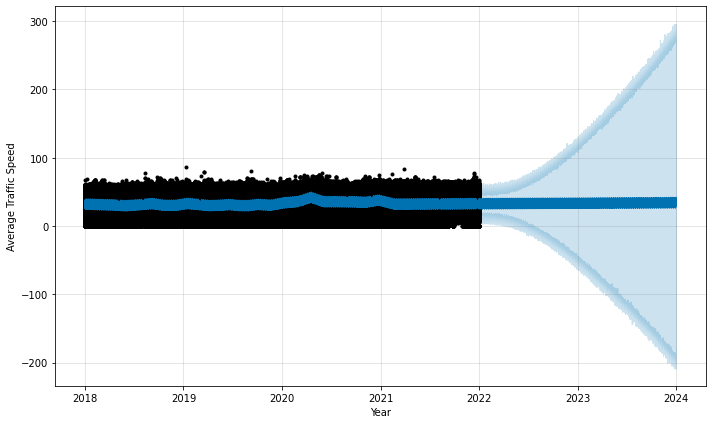

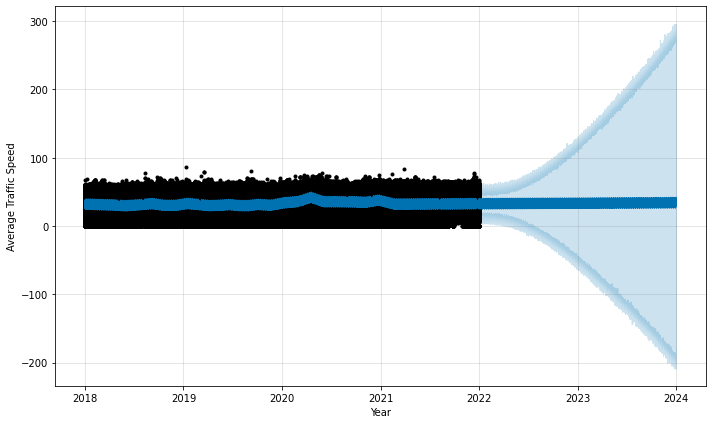

In [23]:
fig_trends = ts_model.plot(df_forecast, xlabel='Year', ylabel='Average Traffic Speed')
display(fig_trends)

/Users/minoseah629/Library/Python/3.8/lib/python/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/minoseah629/Library/Python/3.8/lib/python/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


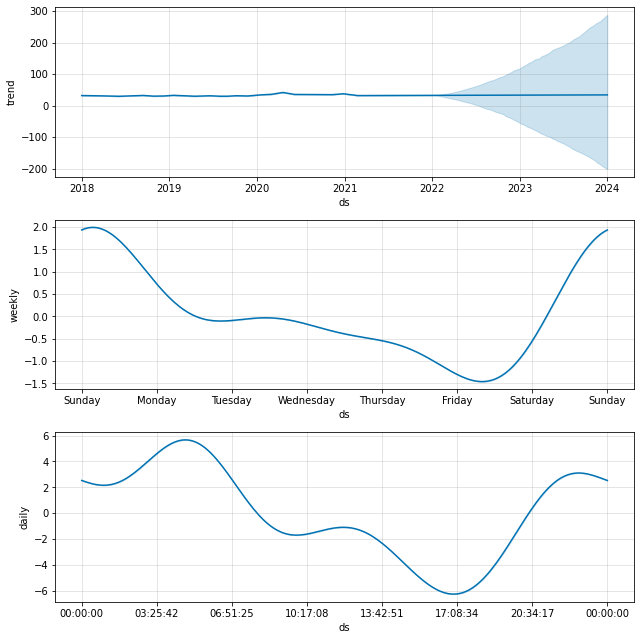

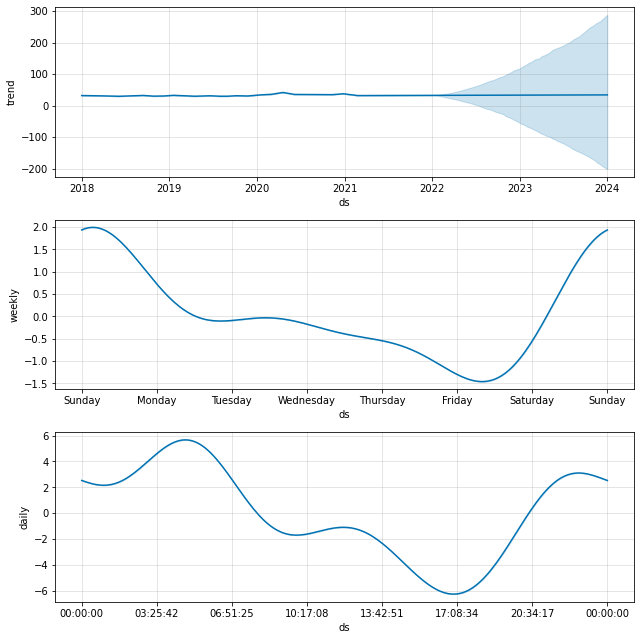

In [24]:
fig_components = ts_model.plot_components(df_forecast)
display(fig_components)

In [27]:
from prophet.plot import plot_plotly

plot_plotly(ts_model, df_forecast, xlabel='Date', ylabel='Average Traffic Speed')

NameError: name 'go' is not defined